#CTGAN with LGBM classifiwer with different data sizes

In [ ]:
# 1) Install CTGAN
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.4 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score # Added f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Added tqdm

df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from lightgbm import early_stopping

def experiment_1_scaling_ctgan(X_train_scaled, y_train, X_test_scaled, y_test, scaler,
                               n_synth=25000, epochs=300):

    results = []
    sizes = [0.01, 0.05, 0.1, 0.5, 1.0]

    fraud_data = X_train_scaled[y_train == 1].reset_index(drop=True)
    nonfraud_data = X_train_scaled[y_train == 0].reset_index(drop=True)

    for frac in tqdm(sizes, desc="CTGAN Experiment Loop"):

        sample_size = int(len(fraud_data) * frac)
        fraud_subset = fraud_data.iloc[:sample_size, :].copy()


        ctgan = CTGAN(
            embedding_dim=128,
            generator_dim=(256, 256),
            discriminator_dim=(256, 256),
            generator_lr=2e-4,
            generator_decay=1e-6,
            discriminator_lr=2e-4,
            discriminator_decay=1e-6,
            batch_size=500,
            epochs=epochs,
            pac=10,
            verbose=False
        )
        ctgan.fit(fraud_subset)

        # Generate synthetic frauds
        syn_fraud = ctgan.sample(n_synth)

        X_aug = pd.concat([X_train_scaled, syn_fraud], ignore_index=True)
        y_aug = np.concatenate([y_train, np.ones(n_synth, dtype=int)])


        pos = y_aug.sum()
        neg = len(y_aug) - pos
        scale_pos_weight = (neg / pos) if pos > 0 else 1.0

        clf = LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=64,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )

        # Early stopping on the hold-out set (AUC-PR is 'aucpr' in LightGBM)
        clf.fit(
            X_aug, y_aug,
            eval_set=[(X_test_scaled, y_test)],
            eval_metric='aucpr',
            callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
        )


        y_prob = clf.predict_proba(X_test_scaled, num_iteration=clf.best_iteration_)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        roc = roc_auc_score(y_test, y_prob)
        pr  = average_precision_score(y_test, y_prob)
        f1  = f1_score(y_test, y_pred)

        results.append((int(frac * 100), roc, pr, f1))
        print(f"{int(frac*100)}% fraud used → ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f}")

    return results

In [ ]:
def plot_experiment_1(results):
    import matplotlib.pyplot as plt
    x = [r[0] for r in results]
    roc = [r[1] for r in results]
    pr = [r[2] for r in results]
    f1 = [r[3] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(x, roc, label="ROC-AUC", marker='o')
    plt.plot(x, pr, label="PR-AUC", marker='s')
    plt.plot(x, f1, label="F1-score", marker='^')
    plt.xlabel("Fraud Training Set Size (%)")
    plt.ylabel("Score")
    plt.title("Experiment 1: CTGAN Performance vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.show()


CTGAN Experiment Loop:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 25394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 252845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100433 -> initscore=-2.192422
[LightGBM] [Info] Start training from score -2.192422


CTGAN Experiment Loop:  20%|██        | 1/5 [00:22<01:29, 22.40s/it]

1% fraud used → ROC-AUC: 0.9757 | PR-AUC: 0.8807 | F1: 0.8901
[LightGBM] [Info] Number of positive: 25394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 252845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100433 -> initscore=-2.192422
[LightGBM] [Info] Start training from score -2.192422


CTGAN Experiment Loop:  40%|████      | 2/5 [00:46<01:10, 23.35s/it]

5% fraud used → ROC-AUC: 0.9730 | PR-AUC: 0.8715 | F1: 0.8601
[LightGBM] [Info] Number of positive: 25394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 252845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100433 -> initscore=-2.192422
[LightGBM] [Info] Start training from score -2.192422


CTGAN Experiment Loop:  60%|██████    | 3/5 [01:11<00:48, 24.32s/it]

10% fraud used → ROC-AUC: 0.9719 | PR-AUC: 0.8692 | F1: 0.8276
[LightGBM] [Info] Number of positive: 25394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 252845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100433 -> initscore=-2.192422
[LightGBM] [Info] Start training from score -2.192422


CTGAN Experiment Loop:  80%|████████  | 4/5 [01:39<00:25, 25.43s/it]

50% fraud used → ROC-AUC: 0.9783 | PR-AUC: 0.8754 | F1: 0.8513
[LightGBM] [Info] Number of positive: 25394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 252845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100433 -> initscore=-2.192422
[LightGBM] [Info] Start training from score -2.192422


CTGAN Experiment Loop: 100%|██████████| 5/5 [02:06<00:00, 25.36s/it]

100% fraud used → ROC-AUC: 0.9742 | PR-AUC: 0.8755 | F1: 0.8384


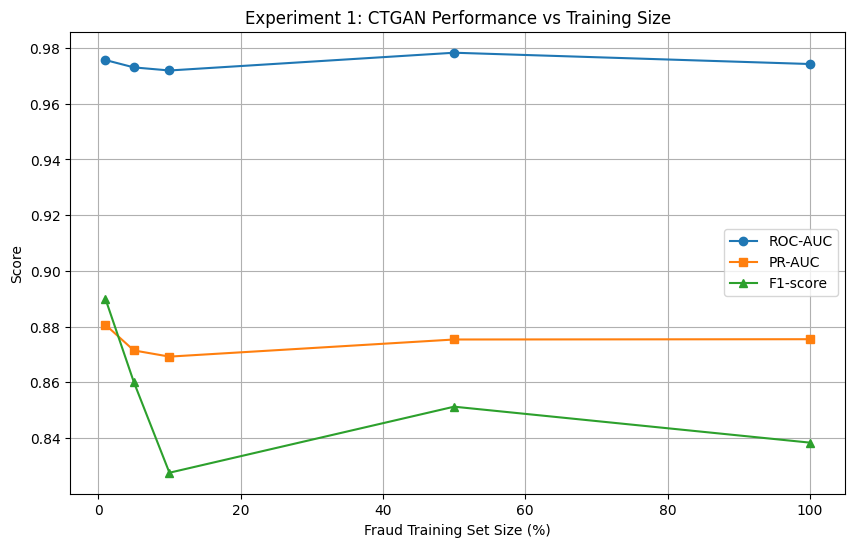

In [ ]:
results_ctgan = experiment_1_scaling_ctgan(X_train_scaled, y_train, X_test_scaled, y_test, scaler)
plot_experiment_1(results_ctgan)


Strength: Very high ROC-AUC (0.97–0.98) with minimal variability → robust and reliable detection ability.

Weakness: F1-score fluctuates, especially at low-to-mid training sizes, reflecting sensitivity in fraud recall.

Best Performance: At higher training sizes (≥80–100%), where PR-AUC (~0.88) and F1 (~0.84–0.85) are more stable.

Overall: CTGAN + LGBM is an excellent framework for fraud detection, with slightly stronger PR-AUC and F1 stability than CGAN+LGBM, making it well-suited for imbalanced data tasks when enough fraud samples are available.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Predicting credit card fraud using conditional generative adversarial network](https://norma.ncirl.ie/6114/), https://www.kaggle.com/datasets/gauravduttakiit/credit-card-fraud-detection-gan

Note- ChatGPT used for understanding results .